In [6]:


Patient = "P014" #"P015/P015_S01_D2024-07-06"
run = None

2025-05-06 17:26:00,178 - INFO - Using device: cpu


Intervall: 5000 - 15000


2025-05-06 17:26:00,775 - INFO - Loaded primary TDMS file: Data/P014/P014_S01_D2024-07-06.tdms
2025-05-06 17:26:00,976 - INFO - Loaded additional TDMS file: Data/P014/P014_S01_D2024-07-06_addCh.tdms
2025-05-06 17:26:00,978 - INFO - Loaded sensor log file: Data/P014/QZFM_log_file.txt
2025-05-06 17:26:00,978 - INFO - Available runs: Brustlage, Ruecken, Noise
2025-05-06 17:26:01,002 - INFO - Model loaded from MCG_segmentation/MCGSegmentator_s/checkpoints/best/model.pth


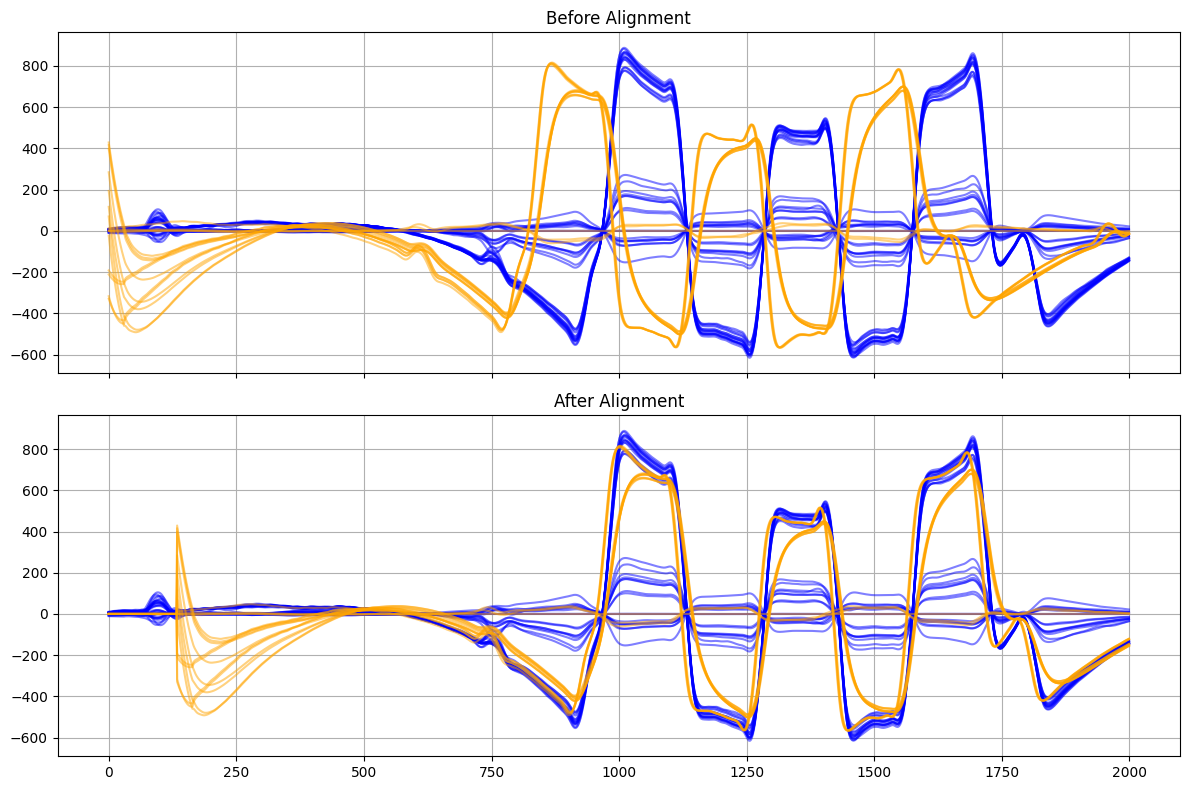

2025-05-06 17:26:02,223 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 43101, Original length: 172406 samples.


In [7]:
import importlib
import analyzer
importlib.reload(analyzer)

from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json
import numpy as np



def load_patient_data(patient: str, run: str = None):
    """
    Load patient data from the specified file.
    """

    overview = pd.read_excel("Data/overview.xlsx")
    dir = "Data/" + patient + "/"
    number = re.findall(r'\d+', dir)
    patient_number = int(number[0]) if number else None


    if overview.loc[overview["Probanten Nr."] == patient_number, "runs"].values[0].strip() == "-":
        print(f"No runs found for patient {patient_number}. Skipping...")
        return
    
    add_filename, file_name = None, None
    
    for file in os.listdir(dir):
        if file.endswith(".tdms") and file.startswith(patient):
            if run and run not in file:
                continue
            if "addCh" in file:
                add_filename = os.path.join(dir, file)
            else:
                file_name = os.path.join(dir, file)
            
    
    log_file_path = os.path.join(dir, "QZFM_log_file.txt")
    sensor_channels_to_exclude = json.loads(overview.loc[overview["Probanten Nr."] == patient_number, "Sensors to exclude"].values[0])

    
    intervall = overview.loc[overview["Probanten Nr."] == patient_number, "Intervall"].values[0]
    intervall = intervall.split(":") if isinstance(intervall, str) else intervall
    intervall_start = int(intervall[0]) if isinstance(intervall, list) else None
    intervall_end = int(intervall[1]) if isinstance(intervall, list) else None
    print(f"Intervall: {intervall_start} - {intervall_end}")

    return Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        sensor_channels_to_exclude=sensor_channels_to_exclude
    ), intervall_start, intervall_end

analysis, intervall_start, intervall_end = load_patient_data(Patient, run)

for k in analysis.key_list:
    if k in ["Brustlage", "Brust", "Bauchlage", "Bauch"]:
        key = k
        break
    
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)



## Apply ICA filtering 

/Users/samuelfriese/Desktop/Projekte/Bachelorarbeit/venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


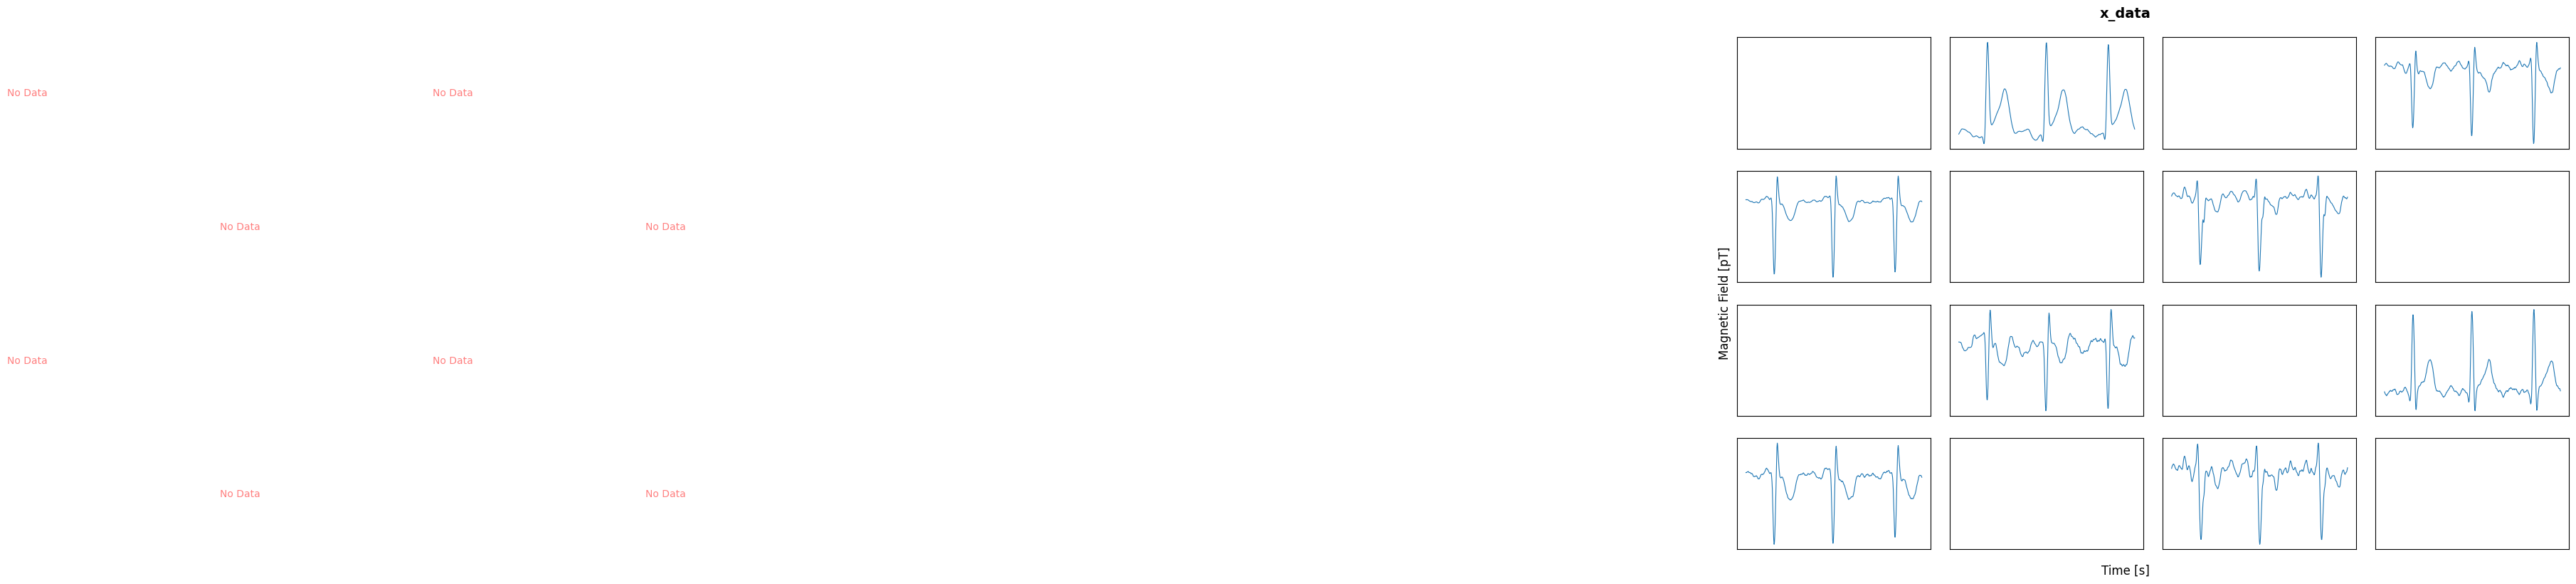

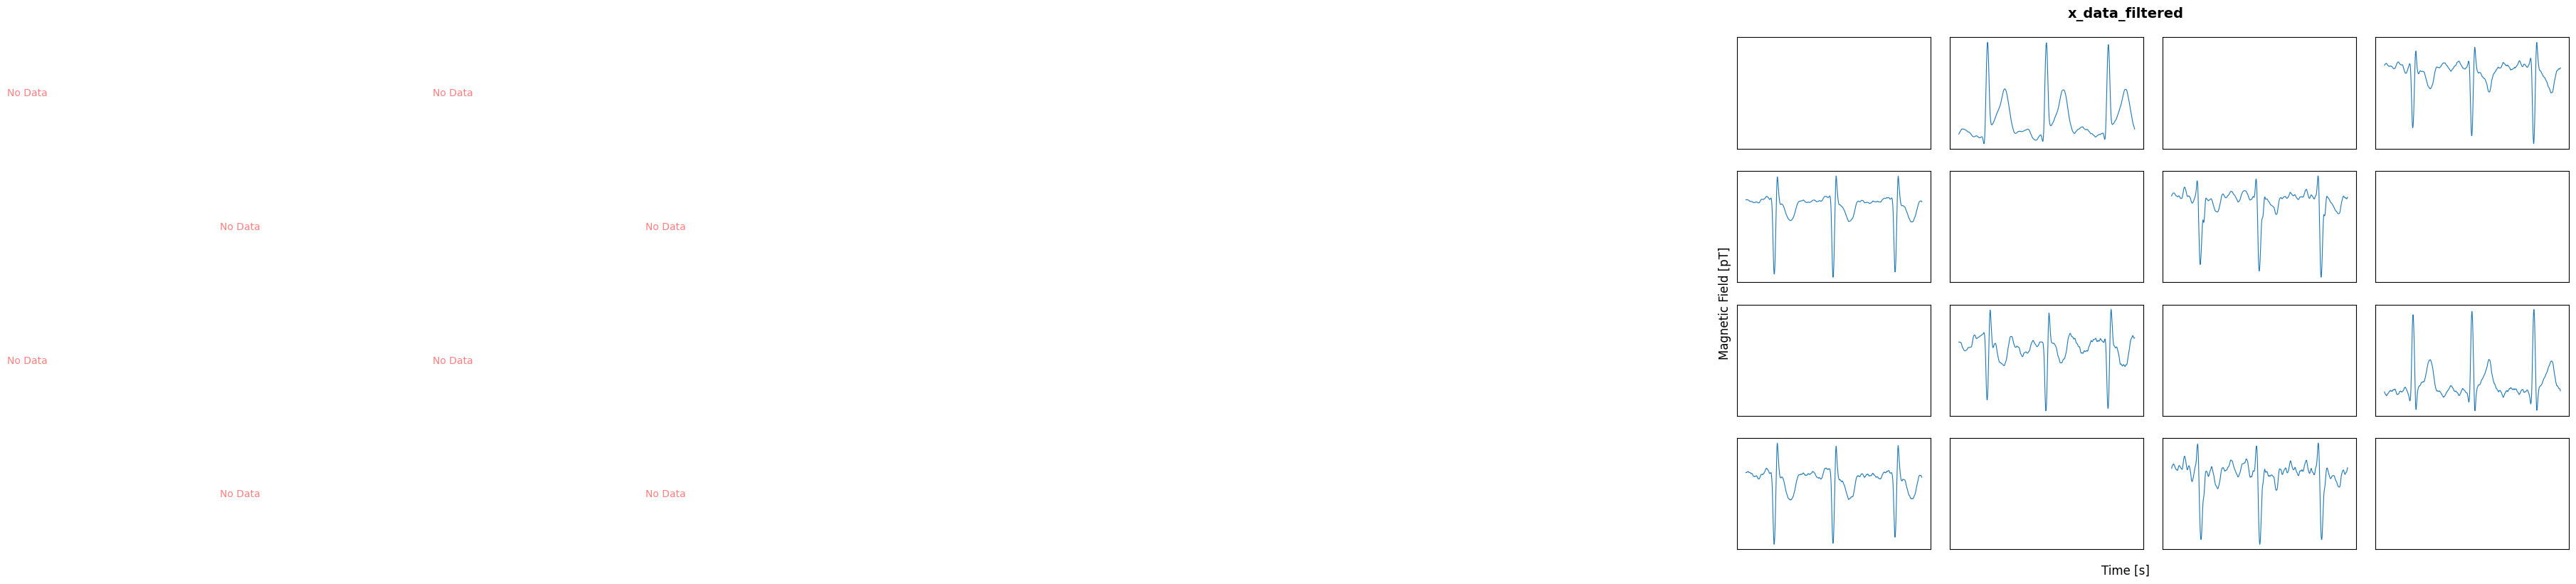

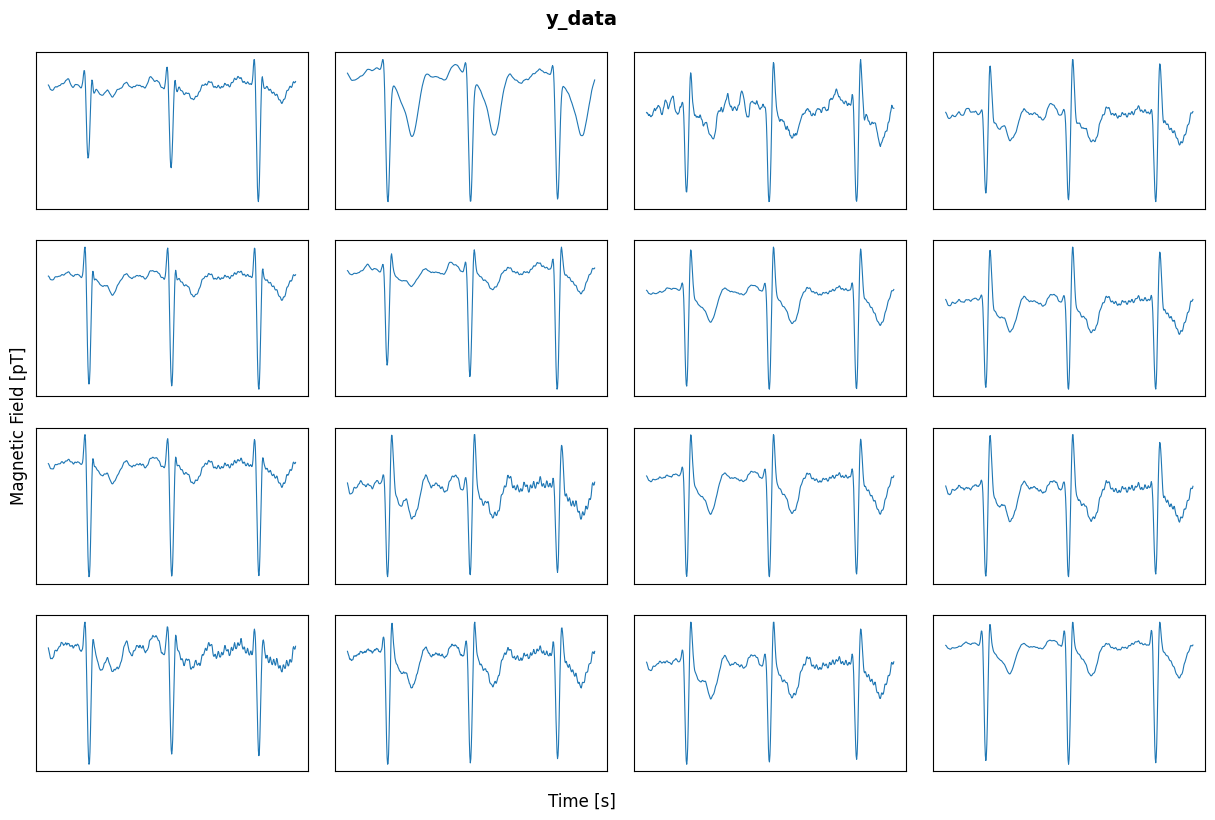

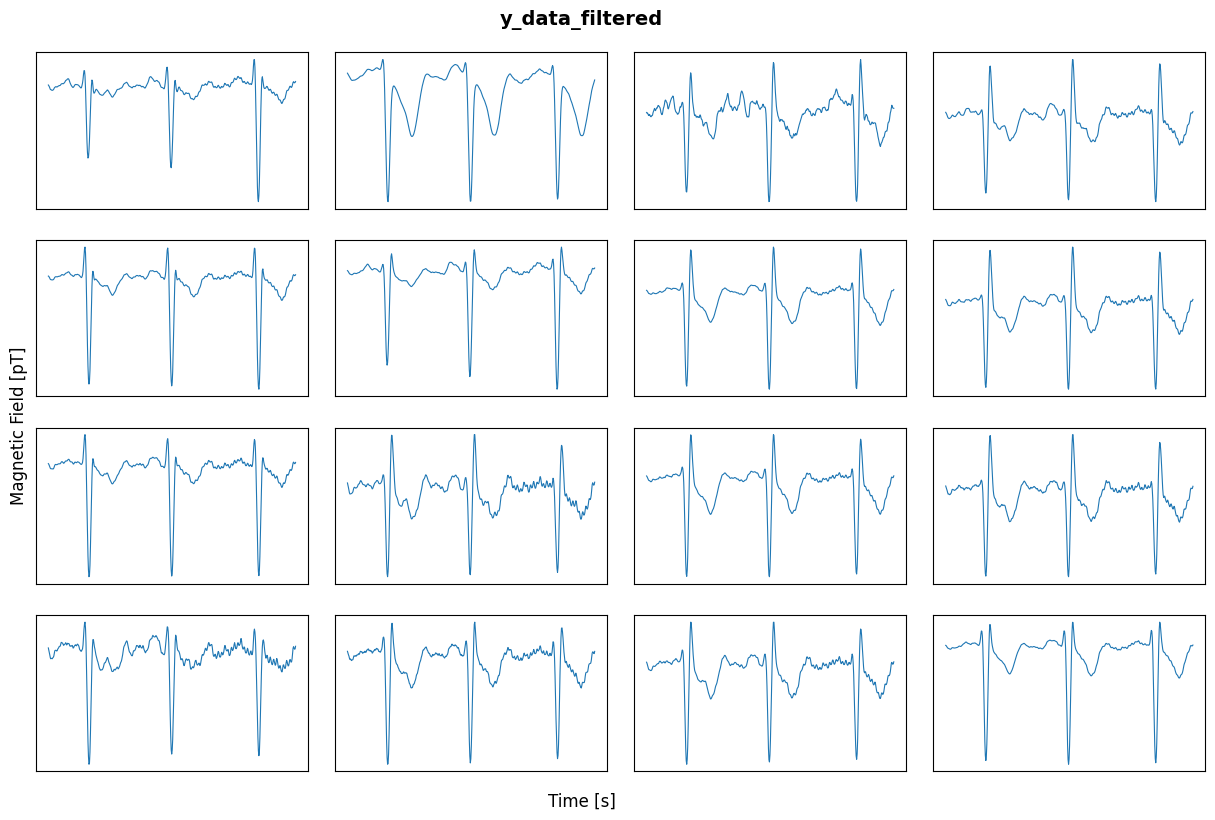

In [8]:


x_data_intervall = x_data[:, :, intervall_start:intervall_end]
y_data_intervall = y_data[:, :, intervall_start:intervall_end]
z_data_intervall = z_data[:, :, intervall_start:intervall_end]
time_intervall = time[intervall_start:intervall_end]
single_run_intervall = single_run[:, intervall_start:intervall_end]


#analysis.plot4x4(z_data[:, :, 250:1250], time[250:1250], name="z_data")

x_data_filtered, _, _, _ = analysis.ICA_filter(x_data_intervall, heart_beat_score_threshold=0.70)
y_data_filtered, _, _, _ = analysis.ICA_filter(y_data_intervall, heart_beat_score_threshold=0.70)
z_data_filtered, _, _, _ = analysis.ICA_filter(z_data_intervall, heart_beat_score_threshold=0.75)


analysis.plot_sensor_matrix(x_data_intervall[:, :, :500], time_intervall[:500], name="x_data")
analysis.plot_sensor_matrix(x_data_filtered[:, :, :500], time_intervall[:500], name="x_data_filtered")
analysis.plot_sensor_matrix(y_data_intervall[:, :, :500], time_intervall[:500], name="y_data")
analysis.plot_sensor_matrix(y_data_filtered[:, :, :500], time_intervall[:500], name="y_data_filtered")
#analysis.plot4x4(z_data_filtered[:, :, 250:1250], time[250:1250], name="z_data_filtered")




Improve Windowing

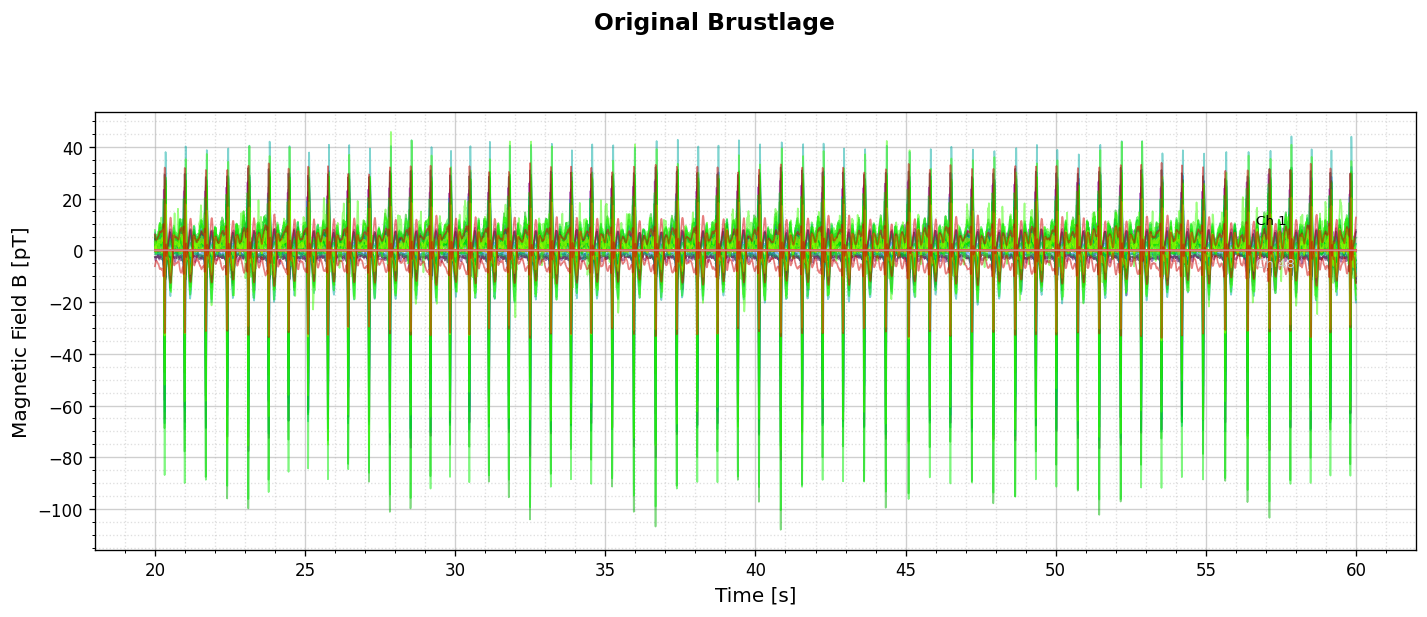

KeyboardInterrupt: 

In [9]:
single_run_filtered = analysis.invert_field_directions(x_data_filtered, y_data_filtered, z_data_filtered, key, 48)




analysis.butterfly_plot(single_run_filtered, time_intervall, 48, f"Original {key}")

# use cleanest channel for peak detection
peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run_filtered, print_heart_rate=True, confidence_threshold=0.7)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(single_run_filtered[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, single_run_filtered[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(single_run_filtered[ch, :], labels[ch, :])


# window averaging
avg_channels, time_window = analysis.avg_window(single_run_filtered, peak_positions, window_left=0.3, window_right=0.5)
analysis.butterfly_plot(avg_channels, time_window, 48, f"Original {key}")



## Test Magnetic Moment fit

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Load data ---
x_data_window, y_data_window, z_data_window = analysis.get_field_directions(avg_channels, key)

print(x_data_window.shape, y_data_window.shape, z_data_window.shape)

# --- Constants and grid ---
grid_spacing = 25.3e-3  # 25.3 mm
MU_0 = 4 * np.pi * 1e-7  # T·m/A

x = np.arange(4) * grid_spacing
y = np.arange(4) * grid_spacing
X, Y = np.meshgrid(x, y)
sensor_positions_np = np.stack([X, Y, np.zeros_like(X)], axis=-1)  # (4,4,3)

# Torch version
sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)

# --- Functions ---
def dipole_field_torch(r_sensor, r0, m):
    r_prime = r_sensor - r0
    r_norm = torch.norm(r_prime, dim=-1, keepdim=True)
    r_hat = r_prime / r_norm
    B = (MU_0 / (4 * np.pi)) * ( (3 * r_hat * torch.sum(r_hat * m, dim=-1, keepdim=True) - m) / (r_norm**3) )
    return B

def fit_dipole_single_time(sensor_positions, B_meas_t, lr=1e-1, n_steps=1000):
    sensors_flat = sensor_positions.view(-1, 3)
    B_meas_flat = torch.tensor(B_meas_t.reshape(-1, 3), dtype=torch.float32)

    valid = torch.norm(B_meas_flat, dim=-1) > 0  # Only keep sensors with nonzero signal
    if torch.sum(valid) == 0:
        print("Warning: No valid sensors at this timestep.")
        return np.zeros(3), np.zeros(3)

    sensors_valid = sensors_flat[valid]
    B_meas_valid = B_meas_flat[valid]

    r0 = torch.nn.Parameter(torch.tensor([0.1, 0.1, 0.1], dtype=torch.float32))  # Start near center
    m = torch.nn.Parameter(torch.randn(3) * 1e-8)  # Small random dipole

    optimizer = torch.optim.Adam([r0, m], lr=lr)

    for step in range(n_steps):
        optimizer.zero_grad()
        B_pred = dipole_field_torch(sensors_valid, r0, m)
        loss = torch.mean((B_pred - B_meas_valid)**2)
        loss.backward()
        optimizer.step()

        # Clip r0 to stay in grid
        #r0.data = torch.clamp(r0.data, 0.0, 4*grid_spacing)

    return r0.detach().numpy(), m.detach().numpy()

def fit_dipole_over_time(sensor_positions, B_meas):
    T = B_meas.shape[-1]
    r0_all = np.zeros((T, 3))
    m_all = np.zeros((T, 3))

    for t in range(T):
        B_meas_t = B_meas[..., t]
        r0, m = fit_dipole_single_time(sensor_positions, B_meas_t)

        r0_all[t] = r0
        m_all[t] = m

    return r0_all, m_all

def predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T):
    sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)
    predicted_signals = {}

    for (i, j) in sensor_indices:
        r_sensor = sensor_positions[i, j]
        signal = np.zeros((3, T))

        for t in range(T):
            r0 = torch.tensor(r0_all[t], dtype=torch.float32)
            m = torch.tensor(m_all[t], dtype=torch.float32)
            B = dipole_field_torch(r_sensor.unsqueeze(0), r0, m)
            signal[:, t] = B[0].detach().numpy()

        predicted_signals[(i, j)] = signal

    return predicted_signals

# --- Prepare field data ---
Bx_meas = x_data_window * 1e-12
By_meas = y_data_window * 1e-12
Bz_meas = z_data_window * 1e-12

B_meas = np.zeros((4, 4, 3, Bx_meas.shape[-1]))
B_meas[..., 0, :] = Bx_meas
B_meas[..., 1, :] = By_meas
B_meas[..., 2, :] = Bz_meas

T = Bx_meas.shape[-1]

# --- Fit ---
r0_all, m_all = fit_dipole_over_time(sensor_positions, B_meas)




Data shapes: (4, 4, 200) (4, 4, 200) (4, 4, 200)
Field ranges: Bx=-3.28e-11 to 1.98e-11 T, By=-4.98e-11 to 1.92e-11 T, Bz=-2.94e-11 to 1.61e-11 T
Fitting time 0/200
Fitting time 10/200
Fitting time 20/200
Fitting time 30/200
Fitting time 40/200
Fitting time 50/200
Fitting time 60/200
Fitting time 70/200
Fitting time 80/200
Fitting time 90/200
Fitting time 100/200
Fitting time 110/200
Fitting time 120/200
Fitting time 130/200
Fitting time 140/200
Fitting time 150/200
Fitting time 160/200
Fitting time 170/200
Fitting time 180/200
Fitting time 190/200


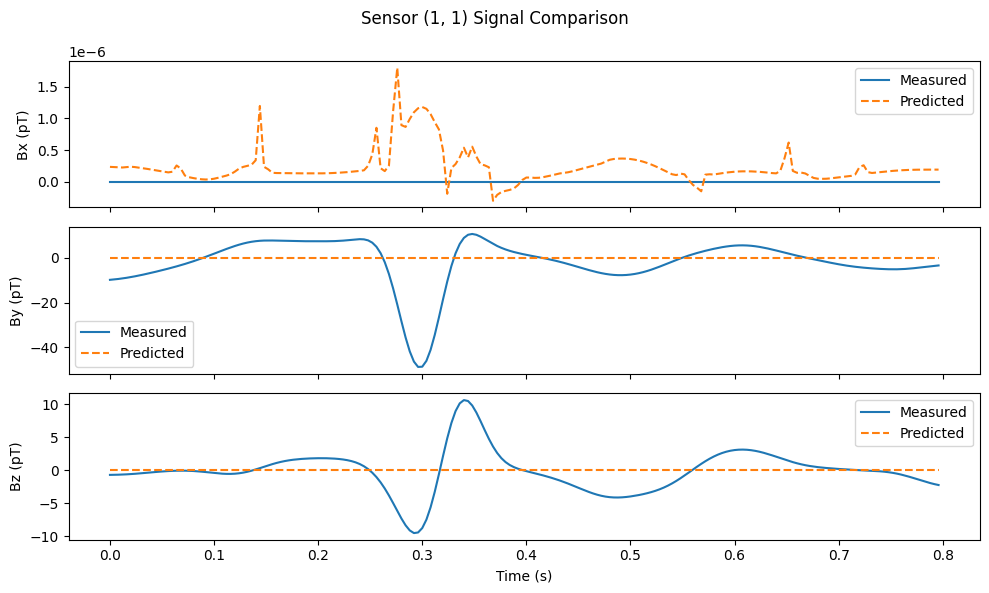

In [38]:
# --- Predict at sensors ---
sensor_indices = [(0,1), (1,1), (3,1)]
predicted = predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T)


# --- Plot ---
sensor = (1,1)
pred = predicted[sensor]  # (3,T)

measured = np.stack([Bx_meas[sensor], By_meas[sensor], Bz_meas[sensor]], axis=0)

time = np.arange(T) / 250  # 250 Hz

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
components = ['Bx', 'By', 'Bz']

for i in range(3):
    axs[i].plot(time, measured[i]*1e12, label='Measured')  # Back to pT
    axs[i].plot(time, pred[i]*1e12, label='Predicted', linestyle='--')
    axs[i].set_ylabel(f'{components[i]} (pT)')
    axs[i].legend()

axs[-1].set_xlabel('Time (s)')
plt.suptitle(f'Sensor {sensor} Signal Comparison')
plt.tight_layout()
plt.show()

## Magentic Heart Vector

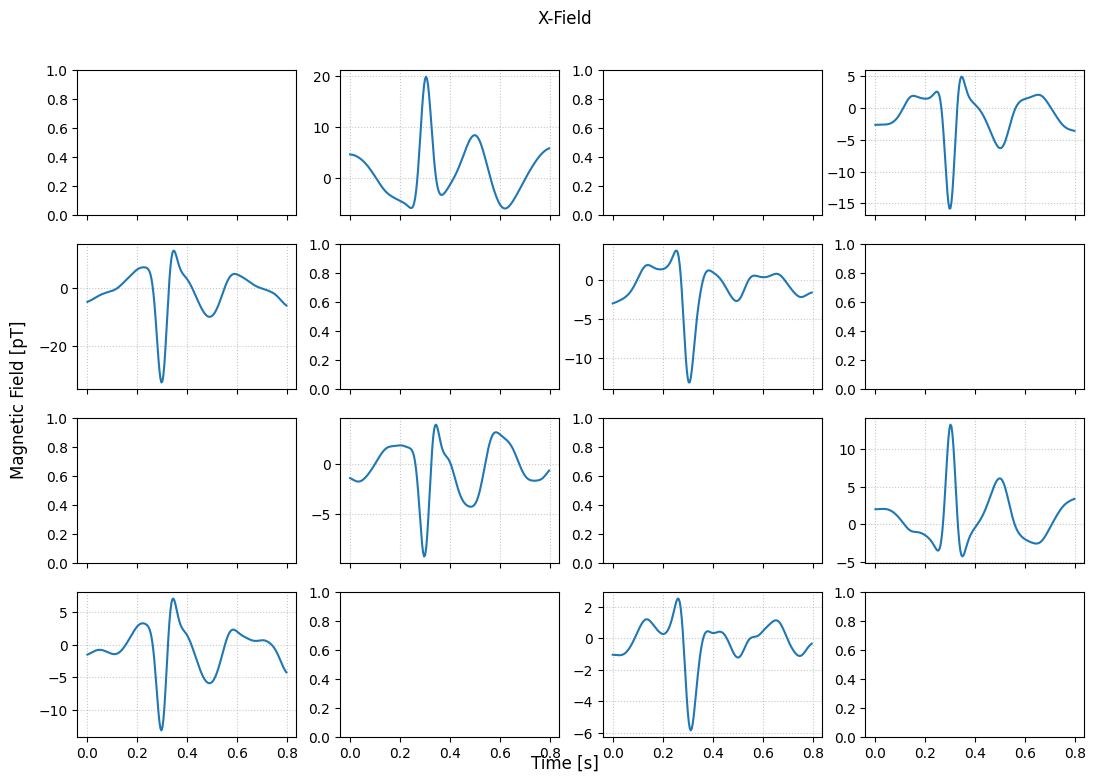

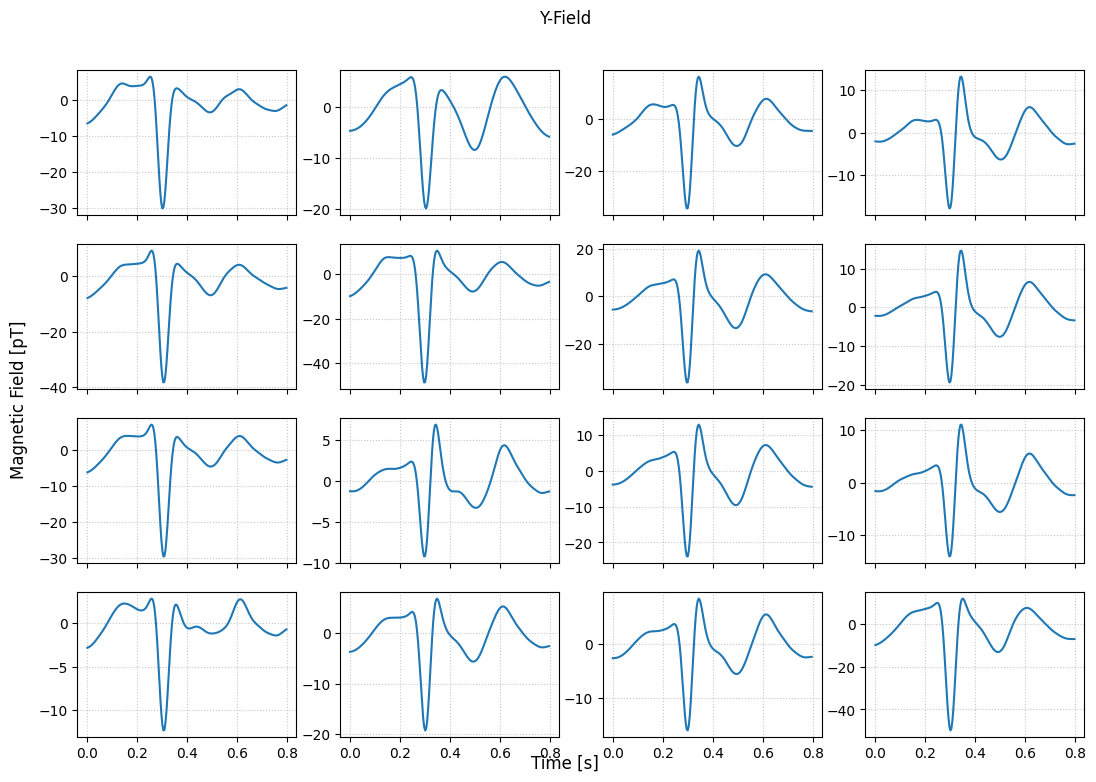

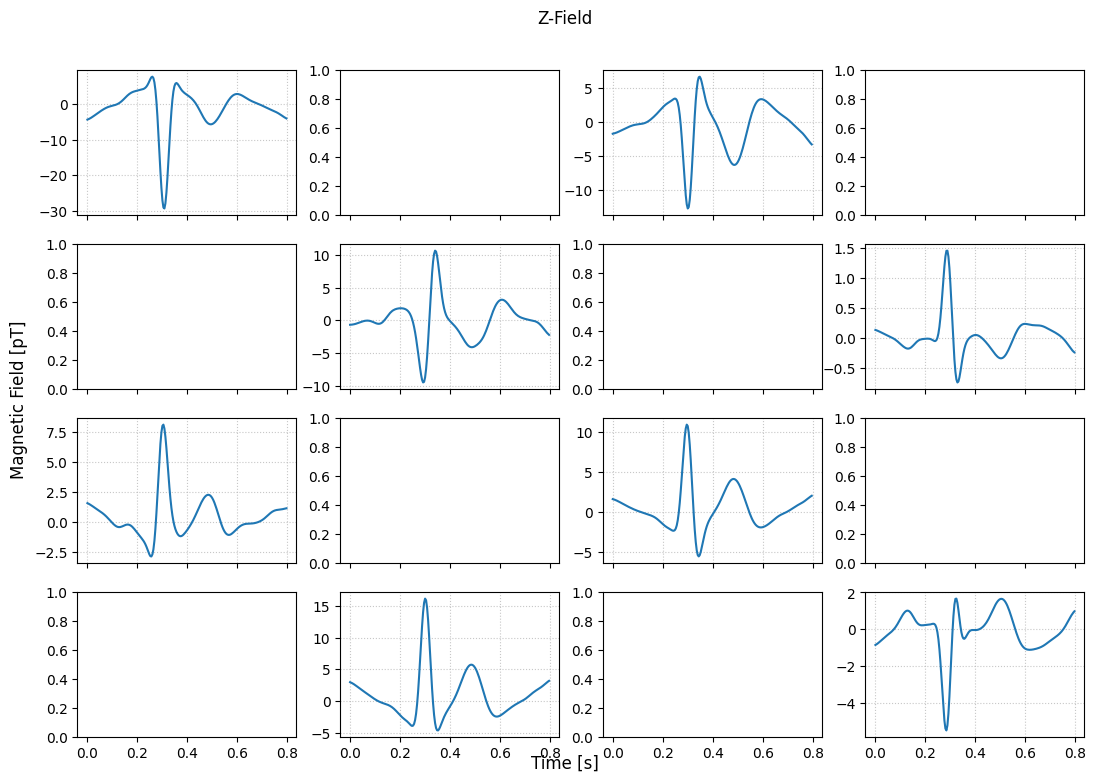

f1_data shape: (2, 200)

Channel Selection Results:
Channel   Conf        P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.7912      22.00       16.00       24.00       0.5556         0.7205      
2         0.8157      10.00       15.00       25.00       1.0000         0.8710      
3         0.7435      20.50       16.50       29.00       0.5882         0.6969      
4         0.8463      12.00       17.50       31.50       0.7143         0.8067      
5         0.8194      10.00       11.00       24.50       1.0000         0.8736      
6         0.8204      9.50        15.00       31.00       0.9091         0.8470      
7         0.8529      13.00       15.00       24.00       1.0000         0.8970      
8         0.8704      14.00       16.50       30.00       0.8696         0.8701      
9         0.9363      2.50        0.00        0.00        0.2597         0.0000      
10

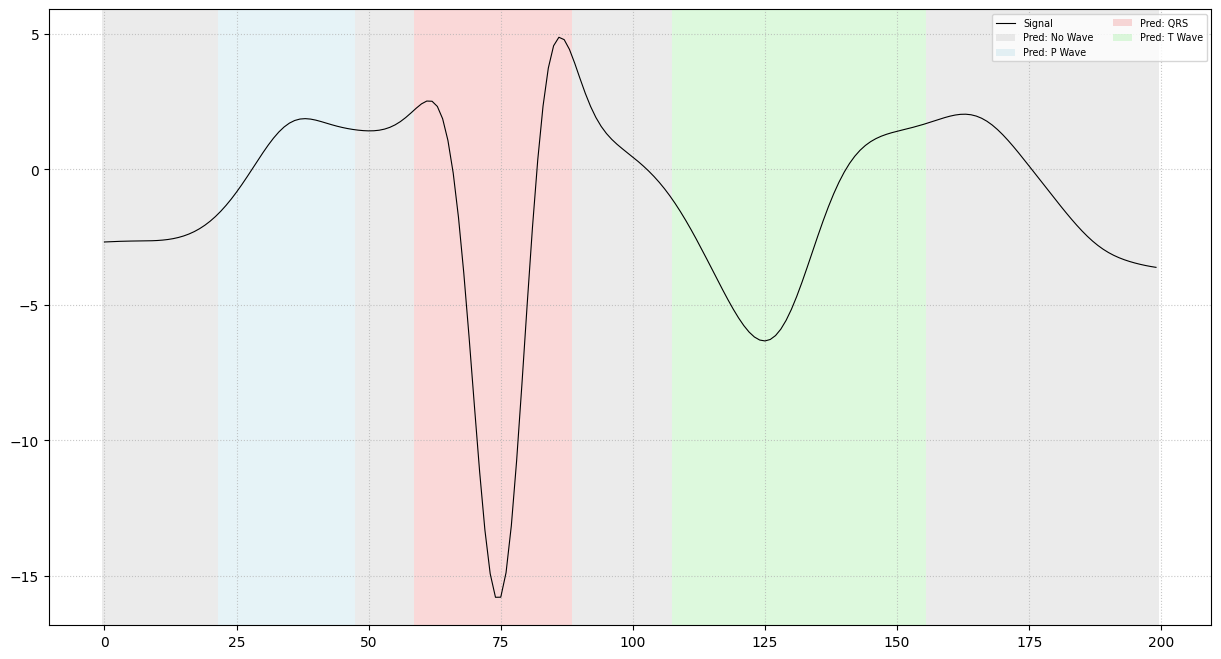

##########################################################################################
T-Wave Segment Extraction
##########################################################################################


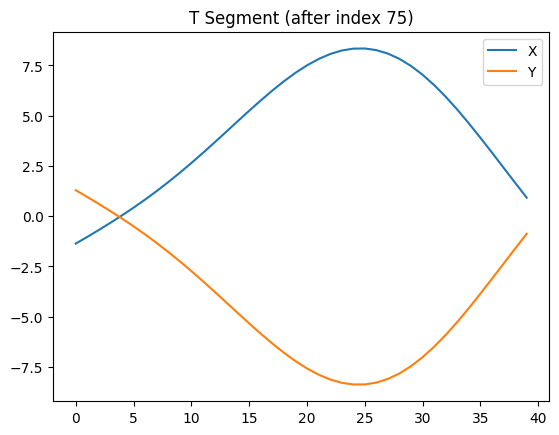

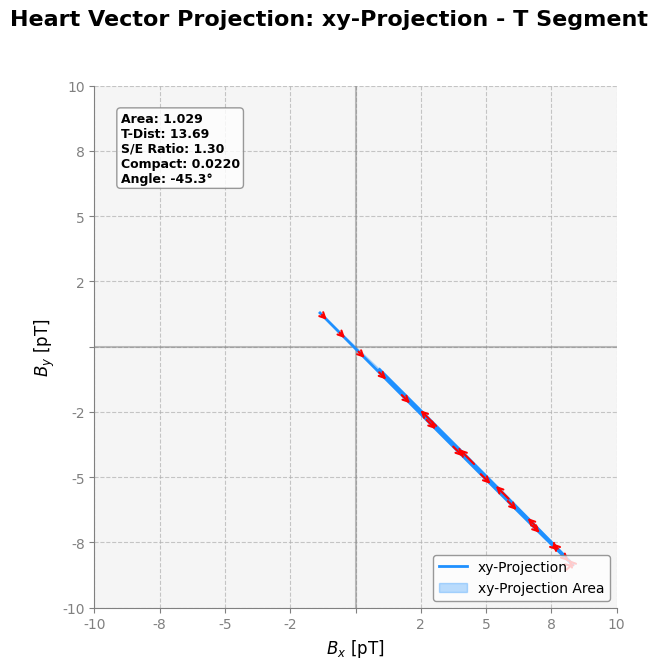

2025-05-06 01:07:01,397 - INFO - Metrics for xy-Projection: Area: 1.029
T-Dist: 13.69
S/E Ratio: 1.30
Compact: 0.0220
Angle: -45.3°


##########################################################################################
QRS to T-Peak Segment with Lorentzian Fit
##########################################################################################


/var/folders/z4/s381pg0d2x72dlyfsty02y0c0000gn/T/ipykernel_26471/3132857895.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


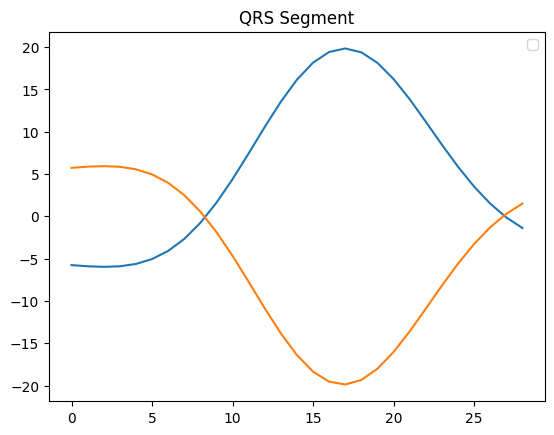

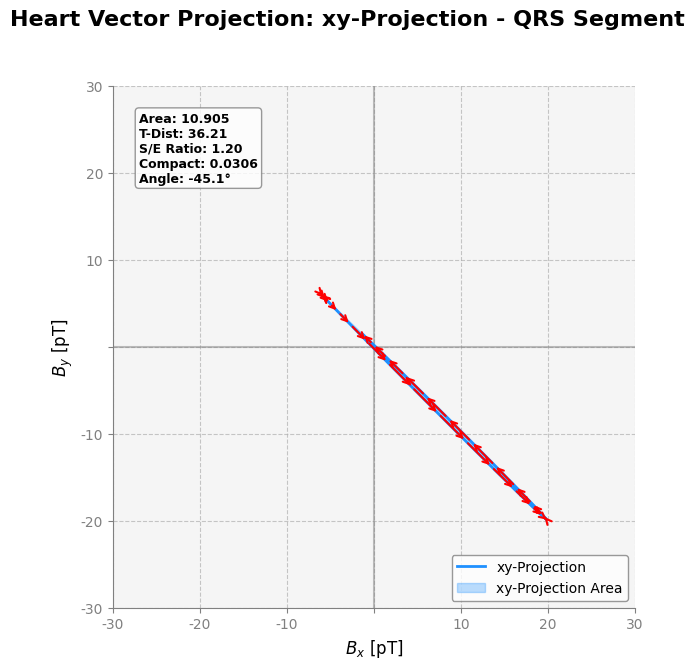

2025-05-06 01:07:01,624 - INFO - Metrics for xy-Projection: Area: 10.905
T-Dist: 36.21
S/E Ratio: 1.20
Compact: 0.0306
Angle: -45.1°


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# --- Load averaged field data ---
x_data_window, y_data_window, z_data_window = analysis.get_field_directions(avg_channels, key)

analysis.plot_sensor_matrix(x_data_window, time_window, name="X-Field")
analysis.plot_sensor_matrix(y_data_window, time_window, name="Y-Field")
analysis.plot_sensor_matrix(z_data_window, time_window, name="Z-Field")

# Use a sample vector for projection
f1_data = np.array([x_data_window[0, 1, :], y_data_window[0, 1, :]])
print(f"f1_data shape: {f1_data.shape}")

# --- Find cleanest channel ---
best_channel, labels, confidence, _ = analysis.find_cleanest_channel(
    avg_channels, confidence_weight=0.7, plausibility_weight=0.3
)

analysis.plot_segmented_signal(avg_channels[best_channel], labels[best_channel])

print("#" * 90)
print("T-Wave Segment Extraction")
print("#" * 90)

# --- Extract T-wave segment ---
mask_t = labels[best_channel] == 3
mask_t[:110] = False  # Ignore early segment
mask_t[175:] = False  # Ignore late segment

t_segment = None
if np.any(mask_t): 
    t_indices = np.where(mask_t)[0]
    t_start, t_end = t_indices[0] - 10, t_indices[-1] - 15
    t_segment = f1_data[:, t_start:t_end]

    plt.figure()
    plt.plot(t_segment[0], label='X')
    plt.plot(t_segment[1], label='Y')
    plt.legend()
    plt.title("T Segment (after index 75)")
    plt.show()

    analysis.plot_heart_vector_projection(t_segment[0], t_segment[1], "xy-Projection", "T Segment")
else:
    print("No T-wave segment found!")

print("#" * 90)
print("QRS to T-Peak Segment with Lorentzian Fit")
print("#" * 90)

# --- Segment from end of QRS to T-peak ---
mask_qrs = labels[best_channel] == 2
mask_qrs[:50] = False
mask_qrs[-50:] = False

if np.any(mask_qrs) and t_segment is not None:
    t_start_qrs = np.where(mask_qrs)[0][0] 
    t_end_qrs = np.where(mask_qrs)[0][-1] 
    # QRS  segment
    segment_qrs = f1_data[:, t_start_qrs:t_end_qrs]

    plt.figure()
    plt.plot(segment_qrs[0])
    plt.plot(segment_qrs[1])
    plt.title("QRS Segment")
    plt.legend()
    plt.show()

    analysis.plot_heart_vector_projection(
        segment_qrs[0], segment_qrs[1],
        "xy-Projection", "QRS Segment"
    )
else:
    print("QRS or T segment not found!")

